 #  第 8 章 推断引擎

<style>p{text-indent:2em;2}</style>

到目前为止，我们的重点是建立模型、解释结果和评估模型，依靠 `pm.sample` 函数的魔力计算后验分布。本章将重点学习此函数背后的推断引擎。概率编程工具（如 `PyMC3` ）使用户不用关心如何进行采样，但了解其原理对全面理解推断过程很重要，同时还能帮助我们了解这些方法何时会失败、为何失败、如何处理等。如果您对后验推断的方法原理不感兴趣，可以跳过本章大部分内容，但强烈建议至少阅读 **8.4 『样本诊断』**节，这一节提供了一些帮助您检查后验样本是否可靠的指导原则。

计算后验分布的方法很多。本章将讨论一些基本思想，并将重点介绍在 `PyMC3` 中实现的最重要的方法。

在本章中，我们将学习：
- 变分方法
- Metropolis-Hastings
- 汉密尔顿蒙特卡洛
- 序贯蒙特卡洛
- 样本诊断
  
---


## 8.1 几类推断引擎

虽然概念上很简单，但贝叶斯方法在数学和数值上都极具挑战性。主要原因是：贝叶斯定理中的分母（即边缘似然）是一个难以处理或计算昂贵的积分形式。因此，后验估计通常使用马尔可夫链蒙特卡洛 (MCMC) 家族的随机采样算法或变分算法进行数值估计。这些方法能够近似几乎任何概率模型的后验分布，因此被称为推断引擎。虽然实践中推断引擎并不总是起作用，但也推动了概率编程语言（如 `PyMC3`) 的发展。

概率编程语言实现了建模过程与推断过程的隔离，进而促进了模型构建、评估、修改或扩展的迭代过程。`PyMC3` 等概率编程语言将推断过程视为黑匣子，用户可以将注意力放在具体问题和模型上，而让 `PyMC3` 去处理计算细节。本书之前的章节一直在这么做，所以可能让你感觉推断是简单的事情。但事实上，在概率编程语言出现之前，推断工作都是由设计概率模型的人自己实现的，通常会根据其模型量身定做，或简化模型，使其适合某些数学近似。并且这种工作现在在学术界仍然在进行。这种量身定制的方法也许更优雅、更有效，但也更容易出错和耗时，即便对专家来说也是如此。

上述定制方法不适合大多数用概率模型解决问题的从业者。像 `PyMC3` 这样的软件欢迎各种背景的人使用概率模型，从而降低了数学和计算的入门门槛。前面的章节主要侧重于贝叶斯建模的基础知识，而本章将在概念层面学习如何实现自动推断，并讨论何时以及为何失败、以及失败时的解决办法。


目前有两大类计算后验分布的数值方法：

**非马尔可夫方法**
- 网格计算法
- 二次逼近法或拉普拉斯近似法
- 变分方法
- 集成嵌入拉普拉斯近似（INLA）方法
  
**马尔可夫方法**
- Metropolis-Hastings法
- 哈密顿蒙特卡洛法
- 序贯蒙特卡洛法

## 8.2 非马尔可夫方法

对于某些问题，非马尔科夫方法的推断非常有效，但有时此类方法只能提供真实后验的粗略近似。

### 8.2.1 网格计算法

网格计算法是一种暴力穷举的方法。其基本思想是既然完整计算出后验很困难，那么退而求其次，只要能够通过先验、似然和边缘似然计算得到点的后验，就至少能够通过均匀间隔获得不那么精细的近似后验。

假设要计算某个单参数模型的后验，网格近似法可以按照如下方式进行：

- 确定参数的一个合理区间（先验会给你点提示）；
- 在以上区间确定一些网格点（通常是等距的）；
- 对于网格中的每个点计算先验、似然和后验。
  
视情况可能会对计算结果进行归一化（把每个点的计算结果除以所有点的计算结果之和）。很容易看出，选的点越多（网格越密）近似的就越好。事实上，如果使用无限多点，可以得到准确的后验。

网格计算法对于多参数场景不太适用，因为随着参数增加，采样空间相比后验空间会急剧增加，换言之，我们需要花费更多时间去计算后验值，但由于维度太大，采样空间呈指数级增长，造成所花费的时间并没有有效提升后验估计的效果，而且计算后验的时间比用后验做预测的时间还长，因而该方法对于大多数统计学和数据科学问题并不太实用。

下面的代码用网格计算法解决了第一章中的抛硬币问题：

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

ModuleNotFoundError: No module named 'seaborn'

In [2]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """
    A grid implementation for the coin-flipping problem
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

假设我们抛硬币 13 次，观察到 3 个头：

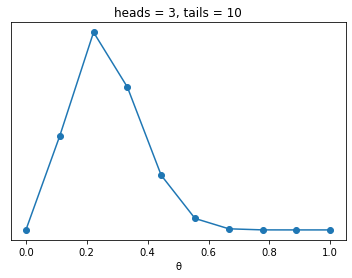

In [3]:
data = np.repeat([0, 1], (10, 3))
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t)
plt.plot(grid, posterior, 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021060716063392.webp
---
align:  center
name: Fig8.1
---
13 次抛硬币实验结果示意图
```

很容易发现：点数量越多（或者网格越小），结果的近似越好。事实上，当趋向于无限个点时，该方法会以增加计算资源为代价，得到精确的后验。

网格法最大的问题是：**此方法不能很好地随参数数量（也称维度）进行调整，而且精度越高，计算要求越大。** 

例如：假设想要使用四个等距点采样一个单位区间（参见图 8.2)，则分辨率为 0.25 个单位，需要 4 个采样点；现假设有一个 2D 问题（图 8.2 中的正方形），使用相同分辨率的网格，则将需要 16 个点；当面向 3D 问题时，将需要 64 个采样点（图 8.2 中的立方体）。也就是说，从 1 维到 3维，采样点增长了16倍。换一个角度，如果希望结果能够更精确些，将分辨率从本例中的 0.25 调整为 0.1 个单位，则每个维度需要 10 个点，整个单位立方体需要 1000 个采样点，又增加了一个很大的量级：


```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210607160809ce.webp
---
align:  center
name: Fig8.2
---
一维、二维和三维网格法示意图
```

除了上面比较直观的点数大幅增加问题，还存在另一种高维空间中存在的特殊现象：<u>相对于整个参数空间而言，随着`参数数量（维度）`增加，后验反而越来越聚集在更小的区域</u>。这在统计学和机器学习中被称为`维度诅咒`，而数学家更喜欢将其称为 `量度集中`。

可以利用`维度诅咒`来讨论各种相关现象，有些现象在低维空间中可能不存在，但在高维空间中存在。例如：

- 随着维数增加，任意一对样本之间的欧式距离变得越来越近。即高维空间中的大多数点，彼此之间的距离基本相同。
- 对于超立方体，大部分体积在其角落，而不是在中间。对于超球体，大部分体积在其表面，而不在中间。
- 在高维空间中，多变量高斯分布的大部分质量并非聚集在平均值或众数，而是在其周围的壳层中；并且随着维数增加，壳层距离高斯分布的平均值越来越远。
  
有关其中一些事实的代码示例，请查看 [链接](https://github.com/aloctavodia/BAP)

所有这些事实表明，如果没有提前考虑和优化在哪些区域做后验评估，那很有可能会花费大部分时间用于计算对后验评估过几乎没有贡献的值。网格法不是一种选择在哪里评估后验分布的明智方法，特别是对于高维问题。

```{note}
此处意指随着维数的增改，维度诅咒现象越来越明显，数据在高维空间中越来越聚集。如果按照均匀网格的做法，就会花费大量时间用于计算数据聚集范围以外的值，而这些值对估计真实后验分布几乎毫无意义，因为真实数据几乎不会位于那些非聚集区域。
```

### 8.2.2 平方近似法

平方近似法（也称为 `拉普拉斯方法` 、 `正态近似法`）用高斯分布 $q(x)$ 来近似后验分布 $p(x)$。

此方法由两个步骤组成：

- 找出真实后验分布的众数，并将其作为 $q(x)$ 的均值。
- 计算 Hessian 矩阵。由此可以计算出的 $q(x)$ 的标准差。
  
第一步可以使用最优化方法进行数值计算，也就是找出函数的最大值或最小值，有许多现成的方法。对于高斯分布，众数和均值相等，所以可以使用众数作为近似分布 $q(x)$ 的平均值。

第二步稍微复杂些，通过计算众数/平均值处的曲率来近似计算 $q(x)$ 的标准差。这可以通过计算海森矩阵的平方根的倒数来实现。海森矩阵是函数二阶导数的矩阵，其逆矩阵为协方差矩阵。

使用 `PyMC3`，可以执行以下操作：

In [4]:
with pm.Model() as normal_approximation:
     # Beta先验
     p = pm.Beta('p', 1., 1.)
     # 二项似然
     w = pm.Binomial('w',n=1, p=p, observed=data)
     # 最大后验点作为近似高斯分布的均值点，该点处的曲率用于近似计算标准差
     mean_q = pm.find_MAP()
     std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0] 
     
     #输出近似高斯分布 q 的均值和标准差
     mean_q['p'], std_q

NameError: name 'pm' is not defined

```{note}
如果您尝试在 `PyMC3` 中使用 `pm.find_map` 函数，您将收到一条警告消息。由于维数灾难，使用最大后验概率 (MAP) 来表示后验，甚至初始化采样方法通常不是一个好主意。
```

可以看下上述 “贝塔-二项模型” 的平方近似的曲线形态：

In [ ]:
# analytic calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , h+1, t+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
        label='Quadratic approximation')

plt.legend(loc=0, fontsize=13)
plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([]);

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021060716150097.webp
---
align:  center
name: Fig8.3
---
贝塔-二项分布的平方近似
```

图 8.3 显示，平方近似并没有那么差。严格地说，该方法只能应用于无界变量，也就是 $\mathbb{R}^N$ 空间中的变量，因为高斯分布是一个无界分布。如果用平方近似法来近似一个有界分布（例如：贝塔分布），会将本来概率密度等于 0 的点错误地估计为正密度（如：贝塔分布中位于定义域 [0，1] 之外的点）。

可以考虑将有界变量变换为无界变量，进而可以使用平方近似法。例如：常用于模拟标准差的半正态分布，定义域制在 [0，∞) 区间内，可以对其取对数，使半正态分布变量转换为无界变量。

平方近似法（拉普拉斯方法）的作用有限，但对某些模型效果很好，并且其生成的近似是后验的解析解，可以大幅度提升推断效率。今年出现一个名为 `积分嵌套拉普拉斯近似 (INLA)方法` 的高级推断方法，其基础构建块也是平方近似。

下节将讨论变分方法，它与拉普拉斯方法有点像，但更灵活、更强大，其中一些方法可自动应用在很多模型中。

### 8.2.3 变分方法

大多数现代贝叶斯统计都是使用马尔可夫方法做推断（见下一节），但对于大数据集而言，马尔可夫方法太慢了，而变分方法此时是一个更好的选择。

变分法与拉普拉斯方法有些相似，其基本思想都是 “用一种更简单的分布来近似后验分布”，但变分法没有将近似分布限定为高斯分布，而是推广到任意可参数化的分布，并且通过最优化方法求得近似分布的参数，进而获得一个和真实分布最相似的精细分布。

**(1) 目标函数设置 -- 证据下界（ ELBO ）**

衡量分布之间相似程度的常用方法是使用 `Kullback-Leibler(KL) 散度`（第 5 章中讨论过）。使用 `KL 散度` 可得：

```{math}
D_{K L}(q(\theta) \| p(\theta \mid y))=\int q(\theta) \log \frac{q(\theta)}{p(\theta \mid y)} d(\theta)  \tag{8.1} \label{式8.1}
```

其中 $q(\theta)$ 是较简单的分布，用做真实后验分布 $p(\theta)$ 的近似， $q(\theta)$ 也被称为`『变分分布』`。通过使用最优化方法，我们试图找出分布 $q$ 的参数（通常称为变分参数），使其在 `KL 散度` 的度量上尽可能接近后验分布。

此处需要注意 KL 散度的方向，一定是 $D_{K L}(q(\theta) \| p(\theta \mid y))$，而不是 $\left.D_{K L}(p(\theta \mid y)) \| q(\theta)\right)$，因为 KL 散度的计算不符合交换率。当然，在另一个方向上写 `KL 散度` 并不是一无是处，实际上在其他地方可以发挥作用，不过该讨论不在本文范围内。

（式 8.1） 的问题是尚不知道后验，无法直接使用它，需要找到另一种方式来表达问题。以下步骤显示了处理方法，如果您不关心中间步骤，请跳到（式 8.7）。

首先，用条件分布的定义做替换：

```{math}
D_{K L}(q(\theta) \| p(\theta \mid y))=\int q(\theta) \log \frac{q(\theta)}{p(\theta, y)} d(\theta) \tag{8.2} \label{式8.2}
```

然后重排公式 8.2：

```{math}
=\int q(\theta) \log \left( \frac{q(\theta)}{p(\theta, y)} p(y) \right) d(\theta) \tag{8.3} \label{式8.3}
```

根据对数性质，得到方程：

```{math}
=\int q(\theta)\left(\log \frac{q(\theta)}{p(\theta, y)}+\log p(y)\right) d(\theta) \tag{8.4} \label{式8.4}
```

重新排列：

```{math}
=\int q(\theta) \log \frac{q(\theta)}{p(\theta, y)} d(\theta)+\int q(\theta) \log p(y) d(\theta) \tag{8.5} \label{式8.5}
```

由于和 $\theta$ 无关，所以可以将 $\text{log} p(y)$ 移出积分，又有 $q(\theta)$ 的积分为 1，可得：

```{math}
=\int q(\theta) \log \frac{q(\theta)}{p(\theta, y)} d(\theta)+\log p(y) \tag{8.6} \label{式8.6}
```

利用对数性质：

```{math}
D_{K L}(q(\theta)|| p(\theta \mid y))=-\underbrace{ \int q(\theta) \log \frac{p(\theta, y)}{q(\theta)} d(\theta)}_{\text {evidence lower bound (ELBO) }}+\log p(y) \tag{8.7} \label{式8.7}
```

因为 $D_{K L} \geq 0$ ，然后 $\text{log} p(y) \geq ELBO$ ，即证据对数 $\text{log} p(y)$ 总是大于等于证据下界 `ELBO`。在固定数据集的情况下，证据可视为常量，因此只需关注 `ELBO` 。（式8.7）表明：**最大化 ELBO 相当于最小化 KL 散度**。因此，最优化的目标函数转换为 “使 ELBO 最大化”。

**（2）设定近似分布 -- 平均场近似法**

上述过程尚未引入对后验的任何近似，只是提供了一个求取（近似分布的参数）最优解的框架。实际上，近似是在选择 $q(.)$ 时才开始发生的。原则上， $q(.)$ 可以是任何想要的分布形式，但实际上应选择易于处理的分布。

一种设置近似分布的方案是： **假设高维后验可以用若干独立的一维分布来描述**。 该方案在数学上可以表示如下：

```{math}
q(\theta)=\prod_{j} q_{j}\left(\theta_{j}\right) \tag{8.8} \label{式8.8}
```

上述近似方式被称为`平均场近似（Mean-Field Approximation）`。平均场近似在物理学中常被用于将（具有许多相互作用的）复杂系统建模为若干相互独立子系统的集合，或者只有在做平均时才考虑相互作用。

理论上，可以人为地为每个参数 $\theta_j$ 设置一个独特的分布 $q_j$。但为简化问题，通常假设 $q_j$ 取自同一分布族，不同 $q_j$ 仅参数不同。 实践中最为常用的分布族是指数族分布，包括：正态分布、指数分布、贝塔分布、狄利克雷分布、伽马分布、泊松分布、类别分布和伯努利分布等。

有了上述要素，就可以将推断问题转化为最优化问题，通过最大化 ELBO 来求解近似分布的参数。原理似乎比较简单，不过在实践中可能会稍微复杂一些。

### 8.2.4  一种通用的自动变分方法 -- ADVI

平均场变分法的主要缺点是：**必须为根据模型的近似分布设定，提出一个特定算法**。也就是说，很难形成一个适用所有模型的通用推断引擎，这显然严重影响了变分推断引擎的设计和推广使用。因此，很多人关注了该问题，希望能够提出变分法的自动化方案。

最近提出的一种被称为 `自动微分变分推断 (ADVI)` 的方法，因为对大数据集具有较好的通用性而得到推广，参见[相关论文](http://arxiv.org/abs/1603.00788) 。在概念层面，`ADVI` 的主要步骤包括：

- 将所有有界分布转换到实数轴上的无界分布，就像之前在平方近似法中所讨论的那样。

- 取用高斯分布作为无界分布的近似（公式 8.8 中的 $q_j$ ）；此处需注意，无界空间上的高斯在原参数空间上可能是非高斯的。

- 使用自动微分作为优化引擎来最大化 ELBO。

`PyMC3` 文档（例如：[链接](https://docs.pymc.io/nb_examples)） 提供了许多关于使用变分推断的示例。

## 8.3 马尔科夫方法

有一系列与随机数相关的方法被统称为 **MCMC 方法**。对于贝叶斯统计，只要能够逐点计算出似然（人工建模与似然假设）和先验值（人工设置先验），MCMC 方法就能从真实后验分布中获得样本。这与前面提到的网格法相同，但与网格法在参数空间平均间隔采样不同，MCMC 方法依据概率密度的大小从不同的分布区域采集不同数量的样本，其性能远优于网格法。

也就是说，MCMC 方法根据参数空间中每个区域的相对概率来确定从该区域抽取样本的次数。例如：如果 A 区域的概率值是 B 区域的两倍，那么从 A 区域抽取的样本数量也将是 B 区域的两倍。因此，即使无法解析计算得到整个后验，也可以使用 MCMC 方法从后验中获取足够有效的样本。

```{note}
注：后验计算公式中分母的边缘似然项很难计算，进而导致很难获得后验的绝对概率值，但 MCMC 方法并不依据绝对概率值来确定采样数量的多少，而是依据相对概率，有效规避了该问题。
```

在统计模型中，人们关心的所有事物，几乎都与某些函数 $f(\theta)$ 的期望值有关，其本质上是与参数 $\theta$ 的分布有关：

```{math}
\mathbb{E}[f]=\int_{\theta} p(\theta) f(\theta) \mathrm{d} \theta \tag{8.9} \label{式8.9}
```

下面是该表达式的一些特例：

- 求后验（公式 1.14）
  
- 求后验预测性分布（公式 1.17）

- 求给定模型的边缘似然（公式 5.13）

（式8.9）基于 $\theta$ 的连续分布，如果能够从该连续分布中抽取合理的样本集，则可以用有限样本近似式 8.9 的结果，如式8.10 所示。这就是 MCMC 方法的基本出发点，当然前提是 “采样密度符合相对概率”。

```{math}
\lim _{N \rightarrow \infty} \mathbb{E}_{\pi}[f]=\frac{1}{N} \sum_{n=1}^{N} f\left(\theta_{n}\right) \tag{8.10} \label{式8.10}
```

（式 8.10）的问题是：等式只能渐近成立。也就是说，需要无限数量的采样才成立！但实践中采样数量越多，则推断所需时间越长、效率越低，因此 MCMC 方法必须寻找到能够尽可能快地收敛到正确答案的采样方法，用尽可能少的样本得到正确答案，这是 MCMC 方法的核心问题，也是本节（`第 8.3 节 “马尔可夫方法”`）的主要内容。

一般来说，要确定 MCMC 样本已经收敛并非易事。因此，实践中必须依靠实证检验来确保有一个可靠的 MCMC 近似 。本书将在`第 8.4 节 “诊断样本” `部分讨论该问题。当然，其他近似（包括非马尔可夫方法）也需要实证检验，但本书不会过多讨论。

为了理解什么是 MCMC 方法，后文把该方法分成两个部分：『蒙特卡洛部分』 和 『马尔可夫链部分』 。

### 8.3.1 蒙特卡洛

蒙特卡洛部分可以用随机数来解释。蒙特卡洛方法是一个非常广泛的算法家族，它使用随机抽样来计算或模拟给定过程。蒙特卡洛是摩纳哥的一个区，那里有一家非常著名的赌场。蒙特卡洛方法的提出者之一 `Stan`，有一个叔叔曾在那儿赌博。

`Stan` 的关键思想是：**虽然许多问题比较难解决，甚至无法用确切的方式表达出来，但可以通过从问题中抽取样本来有效地研究它们**。事实上，蒙特卡洛方法的最早动机是找到纸牌游戏中拿到某张特定牌的可能性。解决该问题的常见方法是利用组合数学，但 `Stan` 认为存在另一种更容易的方法：“进行多次单轮游戏，最后计算其中多少次是我们感兴趣的”。

蒙特卡洛方法的第一个应用解决的是核物理问题，不过该问题在当时的工具手段下很难实现。发展到如今，即使个人计算机也足以利用蒙特卡洛方法解决许多问题，因此，蒙特卡洛方法被广泛应用于科学、工程、工业和艺术领域中。

教科书上有关蒙特卡洛方法的经典案例是估计 $π$ ，可以通过以下蒙特卡洛过程估计：

（1）在边长为 $2R$ 的正方形内随机撒 $N$ 个点。

（2）在正方形内画一个半径为 $R$ 的圆，计算在圆内点的个数 $inside$ 。

（3）利用比例估计 $\bar \pi = 4\frac{inside}{N}$ 。

以下是一些注意事项：

（1）圆和正方形的面积，应当分别与圆内点数和总点数成正比，即是一种均匀的随机分布。

（2）认为该点在圆内的判据是： $\sqrt{\left(x^{2}+y^{2}\right)} \leq R$ 。

（3）正方形的面积是 $(2R)^2$ ，圆的面积是 $πR^2$ ，因此二者面积之比是 $4/π$ 

圆和正方形的面积分别正比于圆内点数 $inside$ 和总点数 $N$，可以通过几行代码来模拟该蒙特卡洛过程，同时计算出估计值与实际值之间的相对误差：

In [ ]:
N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
outside = np.invert(inside)
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9);

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021060716361541.webp
---
align:  center
name: Fig8.4
---
蒙特卡洛方法求取圆的面积
```

上面的代码中，`outside` 变量仅用于绘图，在计算 $\hat \pi$  过程中没有用到。另外一点需要澄清的是，由于这里用的是单位圆，因此在判断一个点是否在圆内时没有计算平方根。



### 8.3.2 马尔科夫链

马尔科夫链是一个数学对象，包含一系列状态以及状态之间的转移概率，如果每个状态转移到其他状态的概率只与当前状态相关，那么这个状态链就称为马尔科夫链。有了马尔科夫链，就可以任取一个初始点，然后根据状态转移概率进行随机游走。

如果能够找到一个马尔科夫链，其状态转移概率正比于待采样的分布（如后验），那么采样过程就变成了简单地在该链上移动。

那么，如何在不知道后验分布的情况下找到这样的状态链呢？有一个概念叫做`细节平衡条件（Detailed Balance Condition）` ，直观上讲，该条件是说，我们需要采用一种可逆的方式移动。也就是说，从状态 $i$ 转移到状态 $j$ 的概率必须和状态 $j$ 转移到状态 $i$ 的概率相等。该条件是充分条件而不一定是必要条件，且比较容易证明，所以被用于大多数 `MCMC方法` 。

总的来说就是，如果我们能够找到满足细节平衡条件的马尔科夫链，就可以保证从中采样得到的样本来自正确的分布。保证细节平衡的最流行的算法是 Metropolis-Hasting 算法。

### 8.3.3 Metropolis-Hastings 算法

某些分布（如高斯分布）有非常有效的样本获取算法，但对于大多数分布，情况并非如此。`Metropolis-Hastings` 能够从任何概率分布 $p(x)$ 中获得与其取值概率成比例的样本，而不用计算归一化因子。这非常有用，因为许多问题（不仅是贝叶斯统计）中计算归一化因子都是非常困难的。

为了更形象地理解这个算法，用下面这个例子来类比。假设我们想知道某个湖的水容量以及这个湖中最深的点，湖水很浑浊以至于没法通过肉眼来估计深度，而且这个湖相当大，网格法显然不是个好办法。为了找到一个采样策略，我们请来了两个好朋友小马和小萌。经过讨论之后想出了如下办法，我们需要一个船和一个很长的棍子：

1. 随机选一个点，然后将船开过去。
2. 用棍子测量湖的深度。
3. 将船移到另一个地点并重新测量。
4. 按如下方式比较两点的测量结果。
   - 如果新的地点比旧的地点水位深，那么在笔记本上记录下新的测量值并重复过程（2）。
   - 如果新的地点比旧的地点水位浅，那么我们有两个选择：接受或者拒绝。
     - 接受意味着记录下新的测量值并重复过程（2）；
     - 拒绝意味着重新回到上一个点，再次记录下上一个点的测量值。

如何决定接受还是拒绝新的测量值呢？这里的一个技巧便是使用 `Metropolis-Hastings 准则`，即接受新的测量值的概率正比于新旧两点的测量值之比。

按照以上过程迭代下去，不仅可以得到整个湖的水容量和最深的点，而且可以得到整个湖底的近似曲面。在这个类比中，湖底的曲面其实就是后验分布，而最深的点就是后验的众数。根据小马的说法，迭代的次数越多，近似的效果越好。事实上，理论保证了在这种情形下，如果能采样无数次，最终能得到完整的后验。幸运地是，实际上对于很多问题而言，只需要相对较少地采样就可以得到一个相当准确的近似。

前面的解释足以对 `Metropolis-Hastings` 有一个概念性的理解。接下来几段包含更详细、更正式的解释。

`Metropolis-Hastings` 算法的步骤如下：

1. 给参数 $x_i$ 赋一个初始值，通常是随机初始化或者使用某些经验值。
2. 从某个提议分布（如高斯分布、均匀分布等简单分布） $q(x_{i+1}|x_i)$ 中随机抽取一个新参数值。这一步可视为对状态 $x_i$ 的扰动。
3. 根据 `Metropolis-Hastings 准则` 计算新参数值的接受概率：
   
   ```{math}
   p_{a}\left(x_{i+1} \mid x_{i}\right)=\min \left(1, \frac{p\left(x_{i+1}\right) q\left(x_{i} \mid x_{i+1}\right)}{p\left(x_{i}\right) q\left(x_{i+1} \mid x_{i}\right)}\right) \tag{8.11} \label{式8.11}
   ```

4. 从位于区间 [0,1] 内的均匀分布中随机抽取一个值，如果第（3）步中得到的接受概率比该值大，那么就接受新参数值，否则仍保持原值。
5. 回到第（2）步重新迭代，直到有足够多的样本（稍后会解释什么叫足够多）。

有几点需要注意：

* 如果选择的提议分布 $q(x_{i+1}|x_i)$ 是对称的，那么可以得到式 8.12，通常称为 `Metropolis 准则` 。
   
```{math}
p_{a}\left(x_{i+1} \mid x_{i}\right)=\min \left(1, \frac{p\left(x_{i+1}\right)}{p\left(x_{i}\right)}\right) \tag{8.12} \label{式8.12}
```

* 步骤（3）和步骤（4）表明：我们总是会转移到一个比当前状态（或参数）概率更大的状态（或参数），对于概率更小的，则会以 $x_{i+1}$ 与 $x_i$ 之比的概率接受。该准则中的接受步骤使得采样过程相比网格法更高效，同时保证了采样的准确性。
* 目标分布（贝叶斯统计中的后验分布）是通过记录下来的采样值来近似的。如果我们接受转移到新的状态 $x_{i+1}$，那么我们就记录该采样值 $x_{i+1}$。如果拒绝转移到 $x_{i+1}$，那么我们就记录 $x_i$。

最后，我们会得到一连串记录值，有时候也称采样链或者迹。如果一切都正常进行，那么这些采样值就是后验的近似。在采样链中出现次数最多的值对应后验中出现概率最大的值（最大后验概率点）。该过程的优点是：`后验分析很简单，可以把对后验求积分的过程转化成对采样链求和的过程` （式 8.10）。

下面的代码展示了 `Metropolis 算法`的一个基本实现。这段代码并不是为了解决什么实际问题，只是用来演示，如果我们知道怎么计算给定点的函数值，就能得到该函数的采样。需要注意代码不包含贝叶斯相关的部分，既没有先验也没有数据。要知道，`MCMC` 是一类能够用于解决很多问题的通用方法。例如，在一个（非贝叶斯的）分子模型中，可能需要一个函数来计算在某个状态 $x$ 下系统的能量而不是简单地调用 `func.pdf(x)` 函数。`metropolis` 函数的第一个参数是一个 `SciPy` 的分布，假设我们不知道如何从中直接采样。

In [ ]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)
    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x
    return trace

在下一个示例中，我们将 `func` 定义为 `beta函数`，原因很简单，因为很容易更改它们的参数获得不同形状。我们将`Metropolis` 获得的样本绘制为直方图，并将真实分布绘制为连续(橙色)线：

In [ ]:
np.random.seed(3)
func = stats.beta(2, 5)
trace = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'C1-', lw=3, label='True distribution')
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated
distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend();

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210608114143f5.webp
---
align:  center
name: Fig8.5
---
 Metropolis 采样算法的后验估计
```

算法效率很大程度上依赖于提议分布；如果建议状态离当前状态很远，拒绝的机会很高；如果建议状态非常接近，则搜索参数空间的速度很慢。在这两种情况下，都需要比不那么极端的情况下更多的样本。通常，提议分布是多变量高斯分布，其协方差矩阵是在调谐阶段确定的。`PyMC3` 会自适应地调整协方差，基本原则是：一维高斯分布的理想接受度为 50% ， $n$ 维高斯分布的理想接受度为 23% 左右。

MCMC 方法通常需要一段时间才能开始从目标分布中获取样本。因此，实践中会进行老化步骤。老化是一种实用的技巧，并不是马尔科夫理论的组成部分；事实上，对于无限样本来说，并不需要老化。考虑到我们只能计算有限样本，删除样本的第一部分只是为了获得更好结果的临时技巧。

现在你应该从概念上掌握了 `Metropolis-Hastings 算法`。也许你需要回过头去重新阅读前面几页才能完全消化。此外，我还强烈建议阅读 `PyMC3` 核心作者写的[博文](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) 。他用一个简单的例子实现了 `metropolis` 方法，并将其用于求解后验分布，文中用非常好看的图展示了采样的过程，同时简单讨论了最初选取的步长如何影响了最终结果。

### 8.3.4 汉密尔顿蒙特卡洛方法/不掉向采样

MCMC 方法（包括 `Metropolis-Hastings`）都在理论上保证如果采样次数足够多，最终会得到后验分布的准确近似。不过，实际中想要采样足够多次可能需要相当长的时间，因此，人们提出了一些 `Metropolis-Hastings 算法`的替代方案。这些替代方案最初都是用来解决统计力学的问题。`汉密尔顿蒙特卡洛方法`，又称 `混合蒙特卡洛（Hybrid Monte Carlo，HMC）`，是此类改进方案之一。简单来说，汉密尔顿这个词描述的是物理系统的总能量，而另外一个名称中的“混合”是指将 `Metropolis-Hastings 算法` 与 `分子力学` 相结合。`HMC 方法` 本质上和 `Metropolis-Hastings` 是一样的，改进的地方在于：原来是随机放置小船，现在有了一个更聪明的办法，将小船沿着湖底方向放置。为什么这个做法更聪明？因为这样做避免了 `Metropolis-Hastings 算法` 的一个主要问题：探索得太慢而且采样结果存在自相关（因为大多数采样结果都被拒绝了）。

```{note}
统计力学是物理学的一个分支，主要研究原子和分子系统的特性。
```

那么，如何才能不必深入其数学细节而理解汉密尔顿蒙特卡洛方法呢？假设我们还是在湖面上坐着船，为了决定下一步将要去哪，我们从当前位置往湖底扔了一个球，受“球状奶牛”的启发 [3]，我们假设球面是理想的，没有摩擦，因而不会被泥巴和水减速。扔下球之后，让它滚一小会儿，然后把船划到球所在的位置。现在利用 `Metropolis-Hastings 算法` 中提到的 `Metropolis 准则` 来选择接受或者拒绝，重复整个过程一定次数。改进后的过程对新位置有更高的接受概率，即使它们的位置相比前一位置距离较远。

现在跳出我们的思维实验，回到现实中来。基于汉密尔顿的方法需要计算函数的梯度。梯度是在多个维度上导数的推广。我们可以用梯度信息来模拟球在曲面上移动的过程。因此，我们面临一个权衡；`HMC` 计算过程要比 `Metropolis-Hastings` 更复杂，但被接受概率更高。对于一些复杂的问题，`HMC 方法` 更合适一些。`HMC 方法`的另一个缺点是：想要得到很好的采样需要指定一些参数。当手动完成此调优时，需要进行一些试验和错误，还需要有经验的用户，这使得此过程不像我们所希望的那样是一个通用的推理引擎。幸运的是，`PyMC3` 配备了一个相对较新的采样器，名为不掉头采样器 `No-U-Turn Sampler(NUTS)`。事实证明，该方法在不需要人工干预(或至少将其最小化)的情况下，为求解贝叶斯模型提供了非常好的效率。NUTS 的问题是，它只适用于连续分布，因为我们无法计算离散分布的梯度。`PyMC3` 通过将 `NUTS` 分配给连续参数，将 `Metropolis` 分配给离散参数来解决此问题。

我强烈推荐 `Chi Feng` 的 [动画](https://chi-feng.github.io/mcmc-demo/) 来补充这部分内容的学习。

### 8.3.5 序贯蒙特卡洛

`Metropolis-Hastings` 和 `NUTS`（以及其他哈密尔顿蒙特卡洛变种）存在的问题是：如果后验有多个峰，并且这些峰被非常低概率的区域分开，则上述方法可能会陷入某个单一众数，而错过其他值。

解决多重极小值问题的主要方法是 `回火法（tempering）` 。回火法借用了统计力学，物理系统可填充的状态数取决于系统的温度：在绝对温度为 $0K$ 时，每个系统都停留在单一状态；另一方面，对于无限大的温度，所有可能状态都是同等可能的；通常我们对处于某一中间温度的系统感兴趣。

对于贝叶斯模型，有一种直观方式来适应这种调温的想法，那就是用以下方式写出贝叶斯定理：

```{math}
p(\theta \mid y)_{\beta}=p(y \mid \theta)^{\beta} p(\theta) \tag{8.13} \label{式8.13}
```

公式 1.4 和 8.13 之间的唯一区别是参数 $\beta$ ，此处被称为 `逆温` 或 `回火参数` 。请注意，对于 $\beta=0$ 我们得到 $p(y \mid \theta)^{\beta}=1$ ，因此调温后的后验 $p(\theta \mid y)_{\beta}$ 就是先验 $p(\theta)$； 并且当 $\beta=1$ 时，调温后的后验是真实的完整后验。由于从先验采样通常比从后验采样容易（通过增加 $\beta$ 的值），因此我们可以从更容易的分布开始采样，然后慢慢地将其变形为真正关心的更复杂的分布。

利用该思想的方法很多，`序贯蒙特卡洛 (Sequential Monte Carlo , SMC)` 就是其中之一。在 `PyMC3` 中实施的 `SMC 方法` 可总结如下：

1. 以 0 初始化参数 $\beta$ 。
2. 从回火后的后验中生成 $N$ 个样本，形成样本集 $S_{\beta}$。
3. 增加一点 $\beta$。
4. 计算 $N$ 个权重 $w$ 构成的集合 $W$ ，权重根据新的回火后验计算得出。
5. 根据 $w$ 对 $S_{\beta}$ 重采样，得到 $S_w$。
6. 运行 $N$ 条 `Metropolis`链，每条链从 $S_w$ 中的不同样本开始。
7. 从步骤 3 开始重复，直到 $\beta \geq 1$。

重采样步骤通过移除概率较低的样本并将其替换为概率较高的样本来实现。`Metropolis` 步骤扰乱了这些样本，有助于探索参数空间。回火法的效率在很大程度上取决于 $\beta$ 的中间值（通常称之为冷却计划）。$\beta$ 的两个相邻值间的差异越小，两个回火后验的距离就越近，从一个阶段转移到下一个阶段就越容易。但如果步长过小，将需要更多中间阶段，会导致大量计算资源浪费，而不会真正提高结果的准确性。

幸运的是，`SMC` 可以自动计算 $\beta$ 的中间值。精确的冷却计划将根据问题难度进行调整；较难采样的分布将比简单分布需要更多的中间阶段。

`SMC` 如图 8.6 所示，第一个子图显示了特定阶段的五个样本（橙色）点。第二个小图显示了这些样本是如何根据它们调温后的后验密度（蓝色）曲线重新加权的。第三个子图显示了从第二个子图中的重新加权样本开始，运行一定数量 `Metropolis` 步长的结果。请注意，后验密度较低的两个样本（最右侧和最左侧的较小圆圈）如何被丢弃，而不是用作新马尔可夫链的种子：


```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021060717005520.webp
---
align:  center
name: Fig8.6
---
序贯蒙特卡洛采样的不同阶段
```

除了 $\beta$ 的中间值外，还根据前一阶段的接受率动态计算了另外两个参数：每个马尔可夫链的步数和提议分布的宽度。

对于 `SMC 算法` 的第 6 步，`PyMC3` 使用了 `Metropolis 算法`。这不是唯一选择，但是一个非常合理的选项，并受到理论和实践结果推动。值得注意的是，即使 `SMC 方法`使用了 `Metropolis`，它也有几个超出 `Metropolis` 优点：

- `SMC` 可以从多峰分布中采样。
- `SMC` 没有老化期。这是由于重加权过程造成的。权重计算采用了如下方式： $S_w$ 不是近似 $p(\theta|y)_{\beta_i}$，而是 $p(\theta|y)_{\beta_{i+1}}$ 。因此，在每个阶段中，`MCMC 链` 都近似地从正确的后验分布开始。
- `SMC` 可以产生低自相关的样本。
- `SMC` 可以用来近似边缘似然，这是 `SMC 方法` 的一个副产品，几乎不需要额外的计算。

## 8.4 诊断样本

本节重点介绍 `Metropolis` 和 `NUTS` 的样本诊断。因为我们是用有限数量的样本来近似后验，所以检查是否有一个有效样本很重要，否则任何来自它的后续分析都将是有缺陷的。我们可以进行几种直观或定量的检验，来发现样本的问题。但这些检验无法证明样本是否正确；只能提供样本似乎合理的证据。如果发现样本有问题，可以尝试很多解决方案：

- 增加采样数。
- 从轨迹的开头删除一些样本。这就是所谓的老化。`PyMC3` 调优阶段有助于减少老化需求。
- 修改采样器参数，例如增加调谐阶段的长度，或增加 `NUTS` 采样器的 TARGET_ACCEPT 参数。在某些情况下，`PyMC3` 会提供修改建议。
- 重新参数化模型，即以不同但等价的方式表达模型。
- 转换数据。我们已经看到了一个这样的例子，在第 4 章，推广线性模型和第 5 章，模型比较中，我们展示了将数据居中可以改进线性模型的采样。

为了使解释更具体，我们将使用具有两个参数的极简分层模型：全局参数 $a$ 和局部参数 $b$（每组参数）。仅此而已，我们在这个模型中甚至没有似然/数据！在这里省略数据是为了强调，我们将讨论的一些属性（特别是在散度一节中）与模型的结构相关，而不是与数据相关。我们将讨论同一模型的两种替代参数化：

In [ ]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7)
    
with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)
    b_shift = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_shift * a)
    trace_ncm = pm.sample(2000, random_seed=7)

中心模型和非中心模型的不同之处在于，对于前者，我们直接拟合群组尺度的参数，而对于后者，我们将群组尺度的参数建模为平移和缩放的高斯模型。我们将使用几个曲线图和数字摘要来探索其中的差异。

### 8.4.1 收敛性

`MCMC 采样`器（如 `NUTS` 或 `Metropolis`) 需要一段时间才能收敛。正如之前解释过的，MCMC 方法在一般条件和无限数量样本下都有收敛的理论保证。不幸的是，在实践中只能获得有限样本，因此必须转而依赖经验的检验，这些检验充其量只能提供一些提示或警告，表明当其失败时，可能会发生糟糕的事情，但不能保证当其没有失败时，一切都是正常的。

直观检查收敛性的一种方法是运行 `arviz.plot_trace` 函数并检查结果。为更好地理解我们在检查这些曲线图时应该查看什么，此处比较一下前面定义的两个模型（参见图 8.6 和 8.7)：

In [ ]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top')

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021060717041601.webp
---
align:  center
name: Fig8.7
---
中心模型的后验分布和迹图
```

In [ ]:
az.plot_trace(trace_ncm, var_names=['a'])

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210607170440ad.webp
---
align:  center
name: Fig8.8
---
非中心模型的后验分布和迹图
```

图 8.8 中的 `KDE` 比 8.7 中的 `KDE` 更平滑；平滑的 `KDE` 是一个好迹象，而不均匀的 KDE 可能表示存在问题，例如需要更多样本或更严重的问题。迹本身（右侧的图）应该看起来像白噪声，这意味着应该看不到任何可识别的模式；我们希望看到一条自由漫游的曲线，如图 8.8 中的迹。当这种情况发生时，我们说有很好的 Burn 。相反，图 8.6 是一个病态行为的例子；如果您仔细地将它与图 8.8 进行比较，会注意到两条链的重叠在 8.8 比 8.7 大，您还会注意到 8.7 中沿着迹的几个区域发生了一些可疑的事情；最清楚的一个是在 500-1000 画之间的区域：您会看到其中一条链（蓝色的）卡住了（基本上是一条水平线）。

图 8.9 显示了一些 Burn 良好（右侧）和 Burn 不良（左侧）的迹的示例。如果有多个区域，例如离散变量或多峰分布，我们希望迹不会在一个值或区域上花费太多时间才移动到其他区域，而是很容易从一个区域跳到另一个区域：


```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_202106071705182a.webp
---
align:  center
name: Fig8.9
---
中心模型的后验分布和迹图

```

好 `MCMC` 样本的另一个特征是自相似的迹。例如，前 10%（大约）应该与迹中的其他部分相似，例如最后 50% 或 10%。再说一次，我们不希望迹中存在某些模式；相反，想要一些嘈杂的东西。使用 `az.plot_trace` 也可以看到这一点。如果迹的第一部分看起来与其他部分不同，这表明需要老化，或者需要更多的样本。如果我们发现其他部分缺乏自相似性，或者看到了某种模式，这可能意味着需要更多的诊断，但通常情况下，我们应该尝试使用不同的参数化。对于困难的模型，我们甚至可能需要应用所有这些策略的组合。

默认情况下，`PyMC3` 将尝试并行运行独立的链（确切数量取决于可用处理器的数量）。这是使用 `pm.sample` 函数中的 `chains` 参数指定的。我们可以使用 `ArviZ` 的  `plot_trace` 或 `plot_forest` 函数直观地检查并行链是否彼此相似。然后，可以将并行链合并为一个单独链进行推断，因此请注意，并行运行链并不浪费资源。

比较独立链的一种定量方法是使用统计量 `R 帽` ，其思想是用链内方差计算链间方差。理想情况下，我们应该期望其值为 1。作为经验规则，值低于 1.1 也没问题；值越高越表示不收敛。我们可以使用 `az.r_hat` 函数计算它；我们只需要传递一个 `PyMC3` 迹对象。默认情况下，还会使用 `az.summary` 函数以及可选的 `az.plot_forest` 来计算 `r_hat 诊断`，如我们在以下示例中所看到的：

In [ ]:
az.plot_forest(trace_cm, var_names=['a'], r_hat=True, eff_n=True)

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210607170617f5.webp
---
align:  center
name: Fig8.10
---
两种模型的森林图
```

对于 `az.summary` 也是如此：

In [ ]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
                      az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

```{image} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210607170651ca.webp
---
align:  center
---
```

### 8.4.2 蒙特卡洛误差

数字摘要返回的数值之一是 `mc_error`，这是对采样引入误差的估计。该估计考虑到样本并不是真正彼此独立的。`mc_error` 是 $n$ 个数据块的平均值 $x$ 的标准误差，每个数据块只是迹的一部分：

```{math}
\mathrm{mc}_{\mathrm{error}}=\frac{\sigma(x)}{\sqrt{n}} \tag{8.14} \label{式8.14}
```

此误差应低于我们希望在结果中看到的精度。

### 8.4.3 自相关

分布（包括后验分布）的理想样本应该具有等于 0 的自相关。当给定迭代的值不独立于其他迭代的采样值时，样本是自相关的。在实践中，MCMC 方法产生的样本是自相关的，特别是 `Metropolis-Hastings`，在较小程度上是 `NUTS` 和 `SMC` 。`ArviZ` 提供了一个方便的函数来绘制自相关曲线：

In [ ]:
az.plot_autocorr(trace_cm, var_names=['a'])

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_202106071708494c.webp
---
align:  center
name: Fig8.11
---
中心模型中的相关性
```

`az.plot_autocorr` 显示采样值与连续点(最多100个点)的平均相关性。理想情况下，应该看不到自相关。在实践中，我们希望样本迅速下降到较低的自相关值。让我们绘制非中心模型的自相关图：

In [ ]:
az.plot_autocorr(trace_ncm, var_names=['a'])

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210608130900c0.webp
---
align:  center
name: Fig8.12
---
非中心模型中的相关性
```

通过比较图 8.11 和图 8.12，可以很容易地看到，非中心模型的样本几乎没有自相关，而中心模型的样本显示出更大的自相关值。


### 8.4.4 有效样本量

有自相关性的采样要比没有自相关性的采样包含的信息量更少，给定采样大小和采样的自相关性之后，可以尝试估计出该采样在采样次数为多少时，没有自相关性且包含信息量不变，该值称为有效采样次数。

参数的自相关程度越高，获得给定精度所需的样本数量就越大，换句话说，自相关会减少有效样本的数量。我们可以在 `ArviZ` 中使用 `az.effect_n` 函数计算有效样本量。通过传递 `effn=True` 参数，还可以通过 `az.summary` 和 `az.plot_forest` 函数计算有效样本大小（参见图 8.9)。

理想情况下，有效样本量应该接近实际样本量。与 `Metropolis` 相比，`NUTS` 的有效样本量通常比 `Metropolis` 高得多，因此，一般来说，如果您使用 `NUTS`，通常需要的样本比使用 `Metropolis` 时要少。

如果任何参数的有效样本量低于 200，`PyMC3` 都会发出警告。作为一般指南，100 个有效样本应该可以很好地估计分布的平均值，但是拥有更多样本将提供每次重新运行模型时变化较小的估计值，这也是使用 200 作为有效样本大小临界值的部分原因。对于大多数问题值，1,000 到 2,000 个有效样本将绰绰有余。

### 8.4.5 发散性

我们现在将探索不包含 `NUTS` 的检验，因为它们基于方法的内部工作，而不是生成的样本的属性。这些检验基于发散性，是诊断样本的一种强大而灵敏的方法。

当我试图设置本书中的模型以避免散度时，您可能已经看到指示出现散度的 `PyMC3` 消息。散度可能表明 `NUTS` 在后验遇到了无法正确探索的高曲率区域；这告诉我们采样器可能缺少参数空间的一个区域，因此结果将是有偏差的。散度通常比这里讨论的测试敏感得多，因此，即使其余测试通过，它们也可以发出问题的信号。散度的一个很好的特点是，它们往往看起来靠近有问题的参数空间区域，因此我们可以使用它们来识别问题所在。可视化散度的一种方法是使用带有 DISGENCES=True 参数的 az.plot_pair：

In [ ]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5),
constrained_layout=True)
for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]},
kind='scatter',
                 divergences=True, contour=False,
divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021060717112515.webp
---
align:  center
name: Fig8.13
---
两种模型的散度情况
```

在图 8.13 中，小（蓝色）点是规则样本，较大（黑色和橙色）点表示散度。我们可以看到，中心模型的散度主要集中在漏斗的尖端。我们还可以看到，非中心模型没有发散，尖端更尖锐。采样器通过分叉告诉我们，它很难从漏斗尖端附近的区域取样。我们确实可以在图 8.13 中检查到，居中的模型在尖端附近没有样本，靠近散度集中的地方。这真是太棒了！

散度也用黑色、“|\”标记表示在 ArviZ 的轨迹图中，如图 8.7 所示。请注意，散度是如何集中在轨迹的病理平坦部分周围的。

可视化散度的另一种有用的方法是用平行的曲线图：

In [ ]:
az.plot_parallel(trace_cm)

```{figure} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210607171240da.webp
---
align:  center
name: Fig8.14
---
散度平行曲线图
```

在这里，我们可以看到 b 和 a 的散度都集中在 0 附近。如图 8.13 和 8.14 所示的曲线图非常重要，因为它们让我们知道参数空间的哪一部分可能有问题，还因为它们帮助我们发现误报。让我解释最后一点。`PyMC3` 使用启发式方法来标记散度，有时，这种启发式方法可能会说我们有散度，但实际上并非如此。一般来说，如果散度分散在参数空间中，我们可能会有误报；如果散度集中，那么我们可能会有问题。当产生散度时，通常有三种方法可以摆脱它们，或者至少减少它们的数量：

增加调优步骤的数量，类似于 pm.sample（调优=1000)。将 TARGET_ACCEPT 参数的值从默认值 0.8 增加。最大值为 1，因此您可以尝试使用诸如 0.85 或 0.9 之类的值。重新参数化模型。正如我们刚刚看到的，非中心模型是中心模型的重新参数化，这导致了更好的样本，并且没有分歧。

### 8.4.6 非居中参数化

从图 8.13 中，可以看到 $a$ 和 $b$ 参数是相关的。因为 $b$ 是形状 10 的向量，所以我们选择绘制 $b(0)$ ，但是 $b$ 的任何其他元素都应该显示相同的模式，事实上，这在图 8.14 中表现得非常清楚。这种相关性和这种特殊的漏斗形状是模型定义和模型部分汇集数据的能力的结果。当 $a$ 的值减小时，$b$ 的单个值变得越来越接近全局平均值。换句话说，收缩级别会越来越高，因此数据会越来越集中（直到完全集中）。允许部分池化的相同结构还引入了影响采样器方法性能的相关性。

在第 3 章“线性回归模型”中，我们看到线性模型也会导致相关性（性质不同）；对于这些模型，一个简单的解决办法是将数据居中。我们可能想在这里做同样的事情，但不幸的是，这不会摆脱漏斗形状带来的采样问题。漏斗形状的微妙特征是相关性随参数空间中的位置而变化，因此将数据居中无助于降低这种相关性。MCMC 方法，如 `Metropolis-Hastings`，在探索高度相关的空间时遇到了问题；这些方法找到合适样本的唯一途径是在前一步的邻域中提出一个新的步骤。结果，探索变得高度自相关且缓慢得令人痛苦。缓慢的 Burn 可能会非常剧烈，以至于简单地增加样本（绘制）的数量并不是一个合理或可行的解决方案。 

`NUTS` 等采样器更适合这项工作，因为它们根据参数空间的曲率提出步骤，但正如我们已经讨论过的，采样过程的效率高度依赖于调优阶段。对于后验的一些几何形状，例如那些由分层模型诱导的几何形状，调整阶段过度调整到链开始的局部邻域，使得对其他区域的探索效率低下，因为新的建议更具随机性，类似于 `Metropolis-Hastings` 的行为。

## 8.5 小结

在本章中，我们概念性地介绍了一些最常用的计算后验分布的方法，包括变分法和马尔可夫链蒙特卡洛方法。我们特别强调通用推断引擎，即设计用于任何给定模型（或至少广泛的模型）的方法。这些方法是任何概率编程语言的核心，因为它们允许自动推断，让用户专注于迭代模型设计和结果解释。我们还讨论了诊断样本的数值测试和视觉测试。如果不能很好地逼近后验分布，贝叶斯框架的所有优点和灵活性就会消失，因此评估推断过程的质量对于我们对推断过程本身的质量是至关重要的。

## 练习


```{image} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210607171503fc.webp
---
align:  left
---
```

```{image} https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_202106071715161a.webp
---
align:  left
---
```